# CSC420: Assignment 4

## Humzah Khan

## Imports

In [2]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Question 4: Homography (60)

## Question 5: Mean Shift Tracking

upload file

In [3]:
from google.colab import files

uploaded = files.upload()

Saving KylianMbappe.mp4 to KylianMbappe.mp4


detect face in the first frame with Viola-Jones

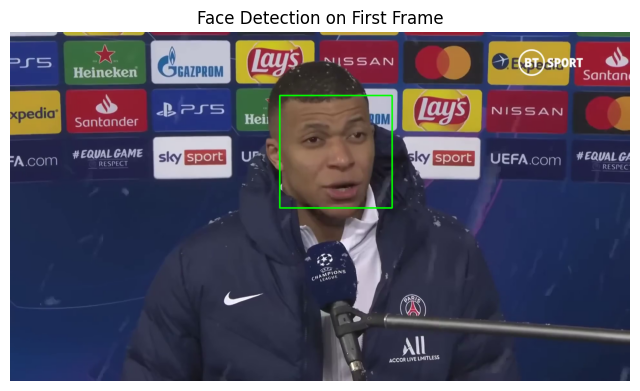

In [4]:
# Load the Haar Cascade for face detection (Viola-Jones algorithm)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the video
video_path = "KylianMbappe.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cap.release()  # Close the video capture

if ret:
    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    # Draw bounding boxes around detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green box

    # Convert BGR to RGB for displaying in Matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("Face Detection on First Frame")
    plt.show()
else:
    print("Error: Could not read video file.")


create histogram

In [5]:
# Convert frame to HSV
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Extract the face region
(x, y, w, h) = faces[0]  # Use the first detected face
face_roi = hsv_frame[y:y+h, x:x+w]

# Create a mask based on saturation and value thresholds
lower_bound = np.array([0, 60, 32])  # Low saturation & value are ignored
upper_bound = np.array([180, 255, 255])
mask = cv2.inRange(face_roi, lower_bound, upper_bound)

# Compute the Hue Histogram
hist = cv2.calcHist([face_roi], [0], mask, [180], [0, 180])
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)  # Normalize

# Save the tracking window
track_window = (x, y, w, h)


In [14]:
# Reopen the video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to find the new location
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Draw the tracking box
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue box for tracking

    # Convert BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the tracking frame
    #plt.imshow(frame_rgb)
    #plt.axis("off")
    #plt.pause(0.03)  # Pause for smooth animation

cap.release()
#plt.show()


IoU with Viola-Jones

In [15]:
def calculate_iou(boxA, boxB):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    Args:
    - boxA, boxB: (x, y, w, h) format

    Returns:
    - IoU score (float between 0 and 1)
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute intersection area
    intersection = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both bounding boxes
    areaA = boxA[2] * boxA[3]
    areaB = boxB[2] * boxB[3]

    # Compute union
    union = areaA + areaB - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    return intersection / union


In [16]:
# Load Viola-Jones Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Reopen video
cap = cv2.VideoCapture(video_path)

# Skip the first frame (since we already processed it)
ret, frame = cap.read()

frame_count = 1  # Start from frame 1
iou_values = []  # Store IoU values
frame_numbers = []  # Store frame numbers

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    frame_count += 1  # Increment frame number

    # Convert frame to HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute back projection using the Hue Histogram
    back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)

    # Apply Mean Shift to update tracking
    ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))

    # Get bounding box from Mean Shift
    x, y, w, h = track_window

    # Convert frame to grayscale for Viola-Jones
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect face using Viola-Jones
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        detected_face = faces[0]  # Take the first detected face
        iou = calculate_iou(track_window, detected_face)
        iou_values.append(iou)
        frame_numbers.append(frame_count)

cap.release()


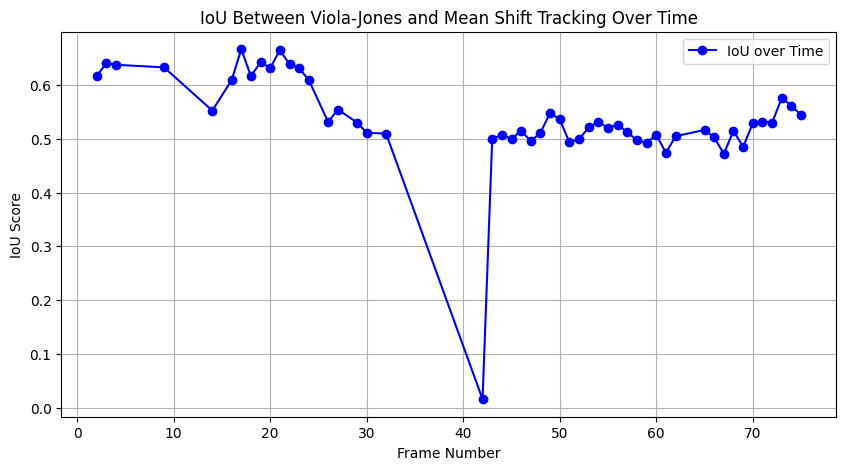

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(frame_numbers, iou_values, marker='o', linestyle='-', color='b', label="IoU over Time")
plt.xlabel("Frame Number")
plt.ylabel("IoU Score")
plt.title("IoU Between Viola-Jones and Mean Shift Tracking Over Time")
plt.legend()
plt.grid(True)
plt.show()


IoU Above 50% Match

In [13]:
# Calculate the percentage of frames where IoU > 50%
iou_threshold = 0.5
num_frames_above_threshold = sum(1 for iou in iou_values if iou > iou_threshold)
total_frames = len(iou_values)

# Compute the percentage
percentage_above_threshold = (num_frames_above_threshold / total_frames) * 100

print(f"Percentage of frames where IoU > 50%: {percentage_above_threshold:.2f}%")


Percentage of frames where IoU > 50%: 78.43%


Frame 17 (above 50%) and Frame 42 (below 10%)

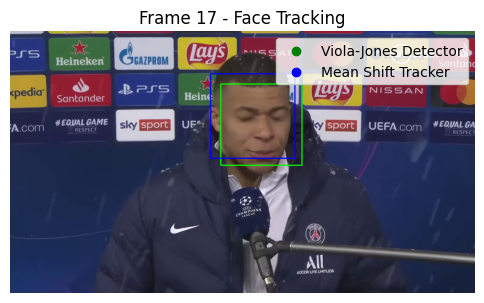

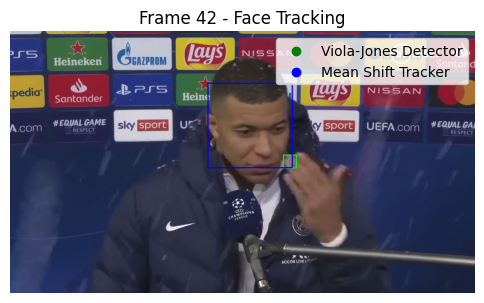

In [10]:
# Reopen video
cap = cv2.VideoCapture(video_path)

# Define the target frames
target_frames = [17, 42]
frames_to_display = {}

frame_count = 1  # Start from frame 1

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    if frame_count in target_frames:
        # Convert to HSV for Mean Shift
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_proj = cv2.calcBackProject([hsv_frame], [0], hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(back_proj, track_window, (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1))
        tracked_box = track_window  # (x, y, w, h)

        # Convert to grayscale for Viola-Jones
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(50, 50))

        if len(faces) > 0:
            detected_face = faces[0]  # Take the first detected face

            # Draw bounding boxes
            x, y, w, h = detected_face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)  # Green (Viola-Jones)

            x, y, w, h = tracked_box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)  # Blue (Mean Shift)

            # Store the frame
            frames_to_display[frame_count] = frame

    frame_count += 1

cap.release()

# Display frames 17 and 42
for frame_number in target_frames:
    if frame_number in frames_to_display:
        frame_rgb = cv2.cvtColor(frames_to_display[frame_number], cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_rgb)
        plt.axis("off")
        plt.title(f"Frame {frame_number} - Face Tracking")

        # Create legend
        plt.scatter([], [], color='green', label="Viola-Jones Detector")
        plt.scatter([], [], color='blue', label="Mean Shift Tracker")
        plt.legend()

        plt.show()


### **Discussion**

The Mean Shift tracker appears to perform better than the Viola-Jones detector overall in the Mbappe video because following the color histogram, is making the object detection more resilient to occlusions and smoother over time. In contrast, Viola-Jones applies frame-by-frame detection, meaning it can misclassify background objects or transient features (like a hand or nail) as faces, leading to sudden errors. Mean Shift’s reliance on histogram back-projection appears to allow it to stay focused on the tracked object, even when part of the face is temporarily blocked. Assuming at least the first frame was correctly identifying the object to get it's histogram.